<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/rnn-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Mouse-Movements on the Server

In [33]:
# for colab
!pip install -q tf-nightly-gpu-2.0-preview

  Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: )
No matching distribution found for tf-nightly-gpu-2.0-preview


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [7]:
import pandas as pd
print(pd.__version__)

0.23.4


In [8]:
df = pd.read_json('../data/sample3.json', typ='series')

In [9]:
len(df)

251

In [10]:
df.head()

0    {'x': [[508, 219, -2, 0, 7], [507, 218, -2, -2...
1    {'x': [[749, 330, 0, 2, 14], [749, 331, 0, 2, ...
2    {'x': [[712, 396, 4, -8, 5], [715, 391, 6, -10...
3    {'x': [[794, 434, -2, -12, 6], [794, 427, 0, -...
4    {'x': [[644, 469, -2, 2, 6], [644, 470, 0, 2, ...
dtype: object

In [11]:
X = [item['x'] for item in df]

In [12]:
X[0]

[[508, 219, -2, 0, 7],
 [507, 218, -2, -2, 16],
 [506, 218, -2, 0, 7],
 [505, 217, -2, -2, 13],
 [504, 217, -2, 0, 14],
 [503, 217, -2, 0, 15],
 [502, 217, -2, 0, 7],
 [501, 217, -2, 0, 29],
 [500, 217, -2, 0, 21],
 [499, 217, -2, 0, 21],
 [498, 217, -2, 0, 22],
 [497, 217, -2, 0, 21],
 [496, 217, -2, 0, 36],
 [496, 217, 0, 0, 390],
 [497, 217, 2, 0, 5108],
 [500, 218, 6, 2, 7],
 [505, 219, 10, 2, 8],
 [509, 220, 8, 2, 7],
 [514, 221, 10, 2, 6],
 [519, 222, 10, 2, 7],
 [522, 222, 6, 0, 7],
 [524, 223, 4, 2, 7],
 [526, 223, 4, 0, 7],
 [529, 223, 6, 0, 8],
 [530, 224, 2, 2, 7],
 [532, 224, 4, 0, 7],
 [533, 224, 2, 0, 7],
 [534, 224, 2, 0, 14],
 [535, 224, 2, 0, 15],
 [535, 224, 0, 0, 7],
 [536, 225, 2, 2, 14],
 [536, 225, 0, 0, 8],
 [536, 226, 0, 2, 22],
 [549, 228, 26, 4, 199],
 [563, 230, 28, 4, 6],
 [576, 232, 26, 4, 7],
 [598, 235, 44, 6, 7],
 [619, 238, 42, 6, 7],
 [628, 241, 18, 6, 9],
 [642, 244, 28, 6, 6],
 [657, 248, 30, 8, 7],
 [666, 251, 18, 6, 6],
 [672, 254, 12, 6, 8],
 [674

In [13]:
y = [item['y'] - 1 for item in df]

In [14]:
y[0]

0

In [15]:
from math import floor

def make_chunks(list_to_chunk, chunk_size):
    length = len(list_to_chunk)
    assert length / chunk_size == floor(length / chunk_size), "length of data must be multiple of segment length"
    for chunk_start in range(0, length, chunk_size):
        yield list_to_chunk[chunk_start : chunk_start + chunk_size]

In [16]:
import numpy as np

CHUNK_SIZE = 25
# only use the final segments 
SEGMENTS = 2

X_expanded = []
y_expanded = []

for x_el, y_el in zip(X, y):
    chunks = list(make_chunks(x_el, CHUNK_SIZE))
    chunks = chunks[len(chunks) - SEGMENTS:]
    labels = [y_el] * SEGMENTS
    for seq, label in zip(chunks, labels):
        X_expanded.append(seq)
        y_expanded.append(label)

X_expanded = np.array(X_expanded)
y_expanded = np.array(y_expanded)

In [17]:
X_expanded.shape

(502, 25, 5)

In [18]:
X_expanded[100]

array([[775, 285,   2,  -2,  14],
       [776, 284,   2,  -2,  22],
       [775, 283,  -2,  -2, 100],
       [774, 284,  -2,   2,  14],
       [765, 296, -18,  24,  14],
       [759, 303, -12,  14,   6],
       [753, 311, -12,  16,   9],
       [747, 318, -12,  14,   7],
       [740, 327, -14,  18,   7],
       [733, 335, -14,  16,   7],
       [727, 341, -12,  12,   7],
       [722, 346, -10,  10,   6],
       [718, 353,  -8,  14,   8],
       [714, 359,  -8,  12,   8],
       [711, 365,  -6,  12,   7],
       [707, 369,  -8,   8,   7],
       [703, 374,  -8,  10,   7],
       [698, 379, -10,  10,   7],
       [694, 383,  -8,   8,   6],
       [689, 388, -10,  10,   7],
       [685, 393,  -8,  10,   8],
       [681, 400,  -8,  14,   7],
       [678, 407,  -6,  14,   7],
       [674, 414,  -8,  14,   7],
       [673, 418,  -2,   8,   8]])

In [19]:
X_expanded[100][0]

array([775, 285,   2,  -2,  14])

In [20]:
y_expanded[100]

0

In [21]:
np.unique(y_expanded)

array([0, 1, 2])

In [22]:
assert np.array_equal(np.unique(y_expanded), [0, 1, 2])

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential, Model

In [24]:
n_steps = len(X_expanded[0])
n_features = len(X_expanded[0][0])
n_buttons = 3

model = Sequential()
model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input", 
# recurrent_dropout makes things slow              
#               dropout=0.1, recurrent_dropout=0.1))
                dropout=0.1))
# model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(BatchNormalization())
model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

W0403 12:43:03.980830 10928 deprecation.py:506] From C:\Users\olive\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
%%time

EPOCHS = 500
BATCH_SIZE = 200

history = model.fit(X_expanded, y_expanded, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

Wall time: 15.3 s


In [26]:
loss, accuracy = model.evaluate([X_expanded], y_expanded, batch_size=BATCH_SIZE)
accuracy

502/502 [==============================] - 0s 30us/sample - loss: 0.3354 - accuracy: 0.8884


0.8884462

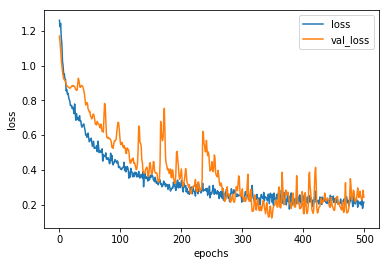

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

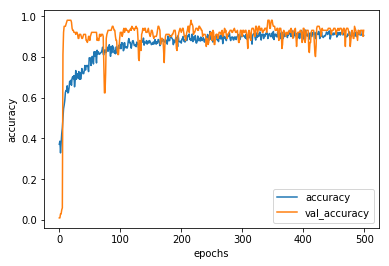

In [28]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])

In [29]:
model.predict([[X_expanded[0]]])

array([[9.9648935e-01, 3.3617197e-03, 1.4893623e-04]], dtype=float32)

In [30]:
model.predict([[X_expanded[0]]]).argmax()

0

In [31]:
y_expanded[0]

0

In [32]:
model.save('ux.hd5')